In [1]:
import numpy as np
import pandas as pd
from scipy.stats import circmean
from scipy.fftpack import fft, rfft, irfft, fftfreq
from scipy.signal import freqz, lfilter, iirnotch, butter, welch, csd, hilbert
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Task 1: Filters and cleaning noise

### Section A

#### Question 1

Voltage-Sensitive Dye Imaging (VSDI) is an optical imaging technique with high spatial and temporal resolution, that converts changes in membrane potential of cortical cells to measurable optical signals. Due to its small signals and considerable sensitivity to noise, VSDI requires a robust experimental setup. For example, Shoham et al., 1999, described a traditional design to study orientation maps in the visual cortex of cats. The cortex of the animal is accessed via a cranial window, illuminated by an epi-illumination stage and imaged by a fast camera through a macroscope optical system. The main computer controls the camera and preliminarily stores and analyses incoming data. A second computer separately generates the visual stimulus that is shown to the animal on a monitor. The computing system performs several tasks processed by different components:

-	A subsystem to monitor heartbeat
-	A microcontroller box to synchronise data acquisition with heartbeat and respiration 
-	A sequence generator to time the visual stimulus
-	A respirator
-	A subsystem made of a PC, a generator box and a monitor to generate the visual stimulus
-	Controllers to adjust illumination and eye shutter
-	Controller box and camera to record cortical activity

#### Question 2

VSDI involves three types of noise. The first two types are caused by unspecific optical signal either from non-neuronal structures that bind to the dye, such as glia cells and the extracellular matrix, or from synaptic potentials at the dendrites below the threshold for an action potential. The third and major type is the wavelength-dependent and blood-related artifact due to heartbeat, as the excitation wavelength of common dyes lies close to the peak absorption of hemoglobin.

#### Question 3

The basic VSDI analysis represents a standard analytical pipeline for optical signals obtained from cortical activity (Ayzenshtat et al, 2010). It is used to improve the quality of the data by increasing its signal-to-noise ratio and removing potential artifacts, primarily heartbeat noise. The basic VSDI analysis involves the following steps:

0. Stratification by stimulus type and pre-filtering trials. Signals originated from different stimulus types are grouped separately and trials with poor eye fixation are filtered.

1. Defining the region of interest. Pixels with sufficient illumination levels, such as at least 15% of the maximal value, are selected to form a circular region of interest that is further analysed.

2. Normalisation by background fluorescence. Because illumination – and thus baseline response – varies with pixel position, optical response is normalised by division with pixel-wise fluorescence value prior to stimulation.

3. Substraction of average blank response. To remove the main artifact in VSDI data – heartbeat pulsation – sessions with only fixation and no stimulation are performed in synchronisation with the animal’s heartbeat, and their mean response over time is determined. This is then subtracted from each trial to obtain an obtical signal free of the heartbeat artifact.

4. Subtraction of linear trend. When processed sessions still exhibit a gradual decline over time, it is possible to linearise them by removing such linear trend.

The resulting optical signals present low bias and can be used to generate neural activation maps of the cortex for individual stimulus types.

#### Question 4

Subtraction of the average blank response is used to reduce the artifact in the optical signal due to hearbeat pulsation. If we were to apply a filter to remove the frequency of heartbeat pulsation, the relevant signal present at such frequency, but produced by the stimulus of interest, would be cancelled as well. Instead, subtraction of the baseline response without stimulation can help preserve the relevant component of the signal and can be easily adapted to individuals with differences in hearbeat rate.

### Section B

In [2]:
# Import data
var4students = np.load("data/var4students.npy", allow_pickle=True)
blank = var4students.item().get("blank")
stimulus = var4students.item().get("stimulus")

In [12]:
# Set experimental parameters
Fs = 100
T, N = blank.shape

time = 1000 * np.arange(T) / Fs

In [40]:
# Define function to compute mean and SEM of trial
def find_stats(arr, keepdims=False):

    arr_mean = np.mean(arr, axis=1, keepdims=keepdims)
    arr_sem = np.std(arr, axis=1) / np.sqrt(arr.shape[1] - 1)

    return arr_mean, arr_sem

# Define function to plot mean response and uncertainty of trial
def plot_stats(time, arr_mean, arr_sem, label="", ax=None):

    if ax == None:
        plt.plot(time, arr_mean, label=label)
        plt.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)
    else:
        ax.plot(time, arr_mean, label=label)
        ax.fill_between(time, arr_mean - arr_sem, arr_mean + arr_sem, alpha=0.5)

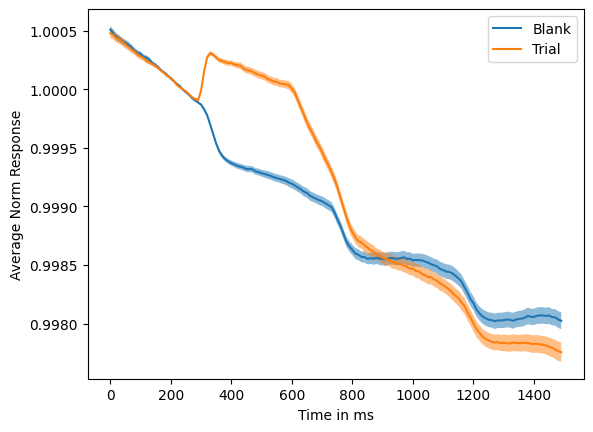

In [66]:
# Compute stats for blank
blank_mean, blank_sem = find_stats(blank)
# Compute stats for stimulus
stimulus_mean, stimulus_sem = find_stats(stimulus)

# Visualise average response for blank
plot_stats(time, blank_mean, blank_sem, label="Blank")
# Visualise average response for stimulus
plot_stats(time, stimulus_mean, stimulus_sem, label="Trial")

plt.xlabel("Time in ms") 
plt.ylabel("Average Norm Response")
plt.legend(loc="upper right")

The average response exhibits oscillations between 2 and 2.5 Hz. In addition, the signal gradually declines about every 200 ms (5 Hz). Notably, such frequency range is typically associated with heartbeat pulsation.

### Section C

In [27]:
# Find frequencies
freq = fftfreq(T, d=1 / Fs)
half_length = freq.size // 2

# Perform FFT on blank
blank_power = np.apply_along_axis(fft, 0, blank - np.mean(blank))
# Perform FFT on stimulus
stimulus_power = np.apply_along_axis(fft, 0, stimulus - np.mean(stimulus))

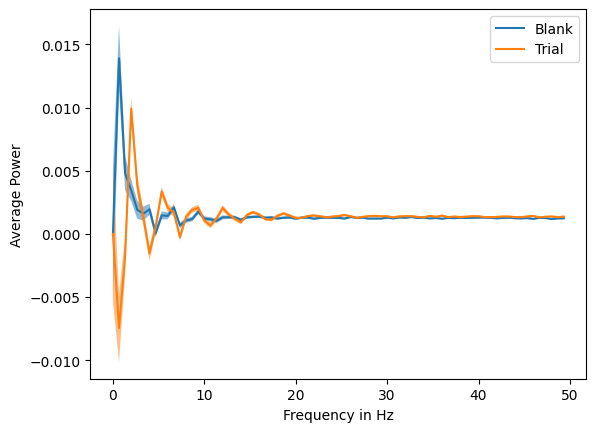

In [65]:
# Compute stats for blank
blank_power_mean, blank_power_sem = find_stats(blank_power)
# Compute stats for stimulus
stimulus_power_mean, stimulus_power_sem = find_stats(stimulus_power)

# Visualise average spectrum for blank
plot_stats(freq[:half_length], blank_power_mean[:half_length], blank_power_sem[:half_length], label="Blank")
# Visualise average spectrum for stimulus
plot_stats(freq[:half_length], stimulus_power_mean[:half_length], stimulus_power_sem[:half_length], label="Trial")

plt.xlabel("Frequency in Hz") 
plt.ylabel("Average Power")
plt.legend(loc="upper right")

In [33]:
# Select example frequency to filter
f0 = 2.5
# Set bandwidth
bandwidth = 0.1

# Design IIR Notch filter
b, a = iirnotch(f0, f0 / bandwidth, Fs)

# Create impulse array
impulse = np.zeros(T)
impulse[0] = 1

# Apply filter to impulse array
impulse_response = lfilter(b, a, impulse)

# Compute the frequency response
freq_range, freq_response = freqz(b, a, fs=Fs)

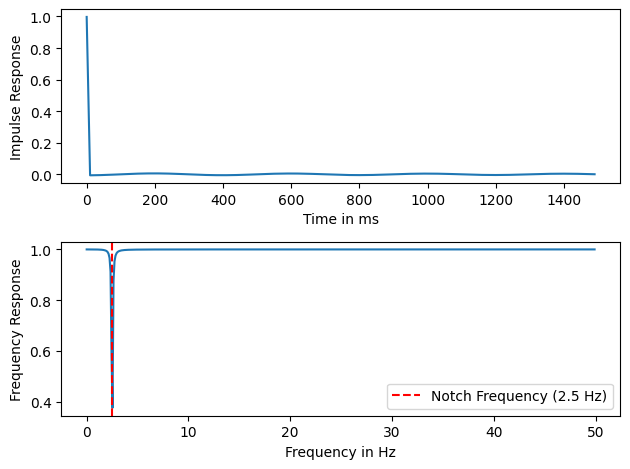

In [34]:
fig, axes = plt.subplots(2)

# Visualise the impulse response
axes[0].plot(time, impulse_response)

axes[0].set_xlabel("Time in ms")
axes[0].set_ylabel("Impulse Response")

# Visualise the frequency response
axes[1].plot(freq_range, freq_response)
axes[1].axvline(f0, color="r", linestyle="--", label=f"Notch Frequency ({f0} Hz)")

axes[1].set_xlabel("Frequency in Hz")
axes[1].set_ylabel("Frequency Response")
axes[1].legend()

plt.tight_layout()

IIR notch filter to remove single frequencies with bandwidth 0.1

In [35]:
def apply_filter(sig, freq, power, Fs, freq_range=[2, 5], bandwidth=0.1):
    
    range_idx = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]), True, False)
    max_idx = np.argmax(power[range_idx, :], axis=0)
    
    heartbeat = freq[range_idx][max_idx]
    filtered_sig = np.zeros_like(sig)
    
    for i in range(heartbeat.size):
        
        b, a = iirnotch(heartbeat[i], heartbeat[i] / bandwidth, Fs)
        filtered_trial = lfilter(b, a, sig[:, i])
        filtered_sig[:, i] = filtered_trial

    return filtered_sig

In [36]:
# Apply filter to each trial of stimulus
filtered_stimulus = apply_filter(stimulus, freq, stimulus_power, Fs)

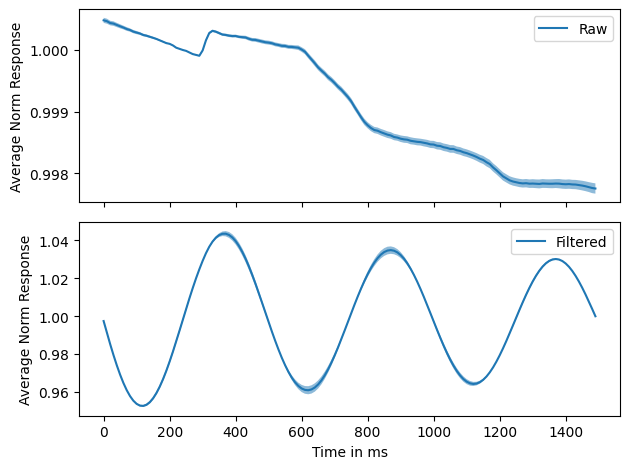

In [64]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for stimulus
plot_stats(time, stimulus_mean, stimulus_sem, ax=axes[0], label="Raw")
# Visualise average response for filtered stimulus
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, ax=axes[1], label="Filtered")

axes[1].set_xlabel("Time in ms")
axes[0].set_ylabel("Average Norm Response")
axes[1].set_ylabel("Average Norm Response")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

### Section D

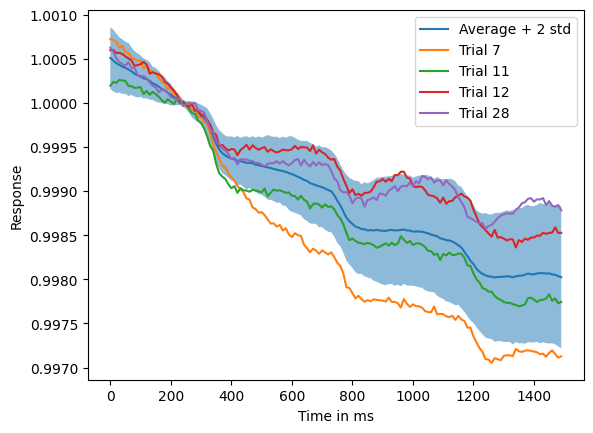

In [47]:
blank_std = np.std(blank, axis=1)
outliers = [7, 11, 12, 28]

plot_stats(time, blank_mean, 2 * blank_std, label='Average + 2 std')

for i in outliers:
    plt.plot(time, blank[:, i], label=f"Trial {i}")

plt.xlabel("Time in ms")
plt.ylabel("Response")
plt.legend()

In [48]:
tidy_blank = np.delete(blank, outliers, axis=1)

tidy_blank_mean, tidy_blank_sem = find_stats(tidy_blank, keepdims=True)

norm_stimulus = stimulus / tidy_blank_mean

norm_stimulus_mean, norm_stimulus_sem = find_stats(norm_stimulus)

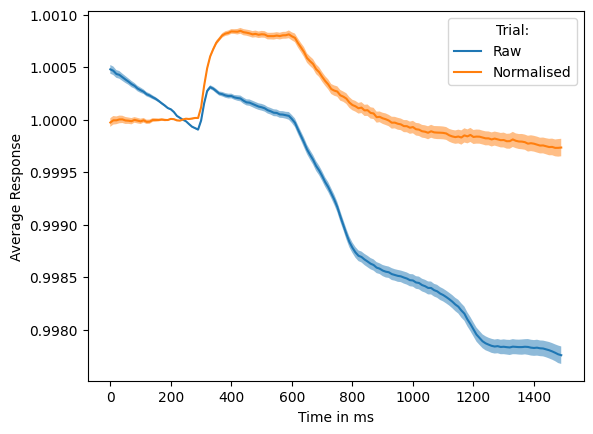

In [63]:
plot_stats(time, stimulus_mean, stimulus_sem, label="Raw")
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, label="Normalised")

plt.xlabel("Time in ms")
plt.ylabel("Average Response")
plt.legend(title="Trial:", loc="upper right")

### Section E

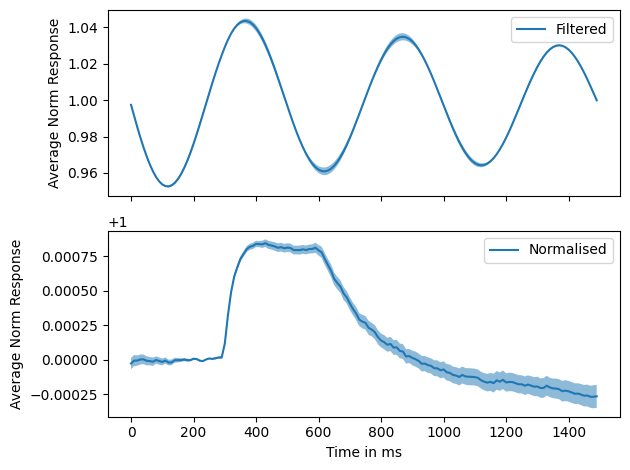

In [59]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for filtered stimulus
plot_stats(time, filtered_stimulus_mean, filtered_stimulus_sem, ax=axes[0], label="Filtered")
# Visualise average response for stimulus
plot_stats(time, norm_stimulus_mean, norm_stimulus_sem, ax=axes[1], label="Normalised")

axes[1].set_xlabel("Time in ms")
axes[0].set_ylabel("Average Norm Response")
axes[1].set_ylabel("Average Norm Response")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

In [60]:
filtered_stimulus_power = np.apply_along_axis(fft, 0, filtered_stimulus - np.mean(filtered_stimulus))
norm_stimulus_power = np.apply_along_axis(fft, 0, norm_stimulus - np.mean(norm_stimulus))

filtered_stimulus_power_mean, filtered_stimulus_power_sem = find_stats(filtered_stimulus_power)
norm_stimulus_power_mean, norm_stimulus_power_sem = find_stats(norm_stimulus_power)

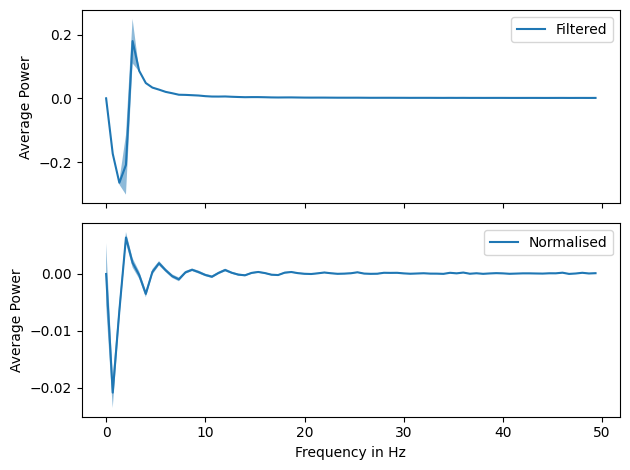

In [62]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise average response for filtered stimulus
plot_stats(
    freq[:half_length], filtered_stimulus_power_mean[:half_length], filtered_stimulus_power_sem[:half_length],
    ax=axes[0], label="Filtered"
)
# Visualise average response for stimulus
plot_stats(
    freq[:half_length], norm_stimulus_power_mean[:half_length], norm_stimulus_power_sem[:half_length],
    ax=axes[1], label="Normalised"
)

axes[1].set_xlabel("Frequency in Hz")
axes[0].set_ylabel("Average Power")
axes[1].set_ylabel("Average Power")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

## Task 2: Fourier Transform

### Section A

A signal $x(t)$ is given for which the Fourier transform $X(\omega)$ must be calculated:

$x(t) = cos(2\pi \alpha t)\cdot cos(2\pi \beta t)$

The trigonometric property of multiplication holds such that:

$cos\alpha\cdot cos\beta = \frac{1}{2}[cos(\alpha - \beta) + cos(\alpha + \beta)]$

It can be applied to $x(t)$ to obtain the following expression:

$x(t) = \frac{1}{2}[cos2\pi (\alpha - \beta)t + cos2\pi (\alpha + \beta)t]$

Moreover, the two elements differ only in the sign between $\alpha$ and $\beta$, which can be substituted with a placeholder:

$\omega_1 = 2 \pi (\alpha - \beta)$ and $\omega_2 = 2 \pi (\alpha + \beta)$

The expression is thus reduced to the following:

$x(t) = \frac{1}{2}[cos\omega_1 t + cos\omega_2 t]$

In addition, it is possible to express the cosine in terms of complex numbers:

$cos(\omega_0 t) = \frac{1}{2}(e^{i \omega_0 t} + e^{-i \omega_0 t})$

The two cosines are substituted with such complex term:

$x(t) = \frac{1}{4}(e^{i \omega_1 t} + e^{-i \omega_1 t} + e^{i \omega_2 t} + e^{-i \omega_2 t})$

Now we are ready to apply the Fourier transform $X(\omega)$ of $x(t)$, which is normally defined as:

$X(\omega) = \frac{1}{2 \pi}\int_{-\infty}^{+\infty}x(t)\cdot e^{-i\omega t}dt$

However, we will refer to such operation as $F(x(t))$ and exploit the fact that the Fourier transform of a complex number equals the following Dirac delta function:

$F(e^{\pm i\omega_0 t}) = \delta(\omega \mp \omega_0)$

Note that the exponent should contain the extra term $2 \pi \omega$, wich was skipped because $\omega_1$ and $\omega_2$ as we defined them already contain the missing elements.

Initially, $X(\omega)$ appears as the Fourier transform of four complex numbers:

$X(\omega) = \frac{1}{4} F(e^{i \omega_1 t} + e^{-i \omega_1 t} + e^{i \omega_2 t} + e^{-i \omega_2 t})$

For the addition rule of integrals, the Fourier transform of the sum is equivalent to the sum of the Fourier transforms:

$X(\omega) = \frac{1}{4}[F(e^{i \omega_1 t}) + F(e^{-i \omega_1 t}) + F(e^{i \omega_2 t}) + F(e^{-i \omega_2 t})]$

Now, the four elements can be solved with the Fourier transform of a complex number, the Dirac function:

$X(\omega) = \frac{1}{4}[\delta(\omega - \omega_1) + \delta(\omega + \omega_1) + \delta(\omega - \omega_2) + \delta(\omega + \omega_2)]$

Finally, $\alpha$ and $\beta$ are substituted back to obtain the answer:

$X(\omega) = \frac{1}{4}[\delta(\omega - \alpha + \beta) + \delta(\omega + \alpha - \beta) + \delta(\omega - \alpha - \beta) + \delta(\omega + \alpha + \beta)]$

We observe that the Fourier transform of a multiplication between two cosine functions correspond to the sum of four Dirac delta functions of different terms. Importantly, the result may vary based on the the type of normalisation (here $\frac{1}{2 \pi}$).

### Section B

The two parameters $\alpha$ and $\beta$ are now given:

$\alpha = 10$ and $\beta = 110$

The two parameters can be plugged in the equation of $x(t)$:

$x(t) = cos(2\pi 10 t)\cdot cos(2\pi 110 t)$

The trigonometric property of multiplication is applied as before:

$x(t) = \frac{1}{2}[cos2\pi (-100)t + cos2\pi (120)t]$

The cosine function is characterised by the property of symmetry such that:

$cos(-x) = cos(x)$

Thus, the negative angle can be replaced with its positive counterpart:

$x(t) = \frac{1}{2}[cos2\pi (100)t + cos2\pi (120)t]$

The Nyquist frequency of a signal is defined as its maximal frequency:

$f_{max} = \frac{f_s}{2} = 120 s^{-1}$

To prevent aliasing, the sampling rate must be at least twice as great as the Nyquist frequency:

$\Rightarrow f_s \ge 2f_{max} = 240 s^{-1}$

In conclusion, the signal must be sampled at a frequency of at least 240 Hz to prevent aliasing.

### Section C

The signal is sampled at two frequencies (160 and 250 Hz) and results are compared.

In [67]:
# Set sampling rates
Fs1, Fs2 = 160, 250
# Set experiment length
T = 2

# Collect sample times
t1 = np.linspace(0, T, T * Fs1)
t2 = np.linspace(0, T, T * Fs2)

The signal is defined as the sum between two cosine functions, sampled at times `t1` and `t2`, respectively.

In [68]:
# Set signal parameters
a, b = 10, 110

y1 = np.cos(2 * np.pi * a * t1) * np.cos(2 * np.pi * b * t1)
y2 = np.cos(2 * np.pi * a * t2) * np.cos(2 * np.pi * b * t2)

The amplitudes for the two versions of the signal are visualised below for a duration of 2 seconds.

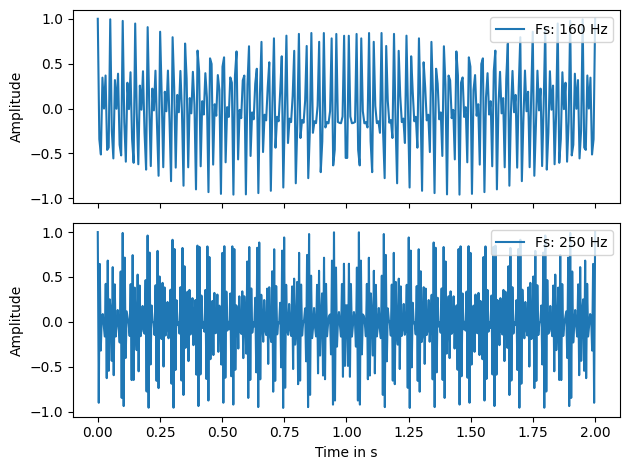

In [76]:
fig, axes = plt.subplots(2, sharex=True)

# Visualise signal at first sampling rate
axes[0].plot(t1, y1, label=f"Fs: {Fs1} Hz")
# Visualise signal at second sampling rate
axes[1].plot(t2, y2, label=f"Fs: {Fs2} Hz")

axes[0].set_ylabel("Amplitude")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time in s")

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.tight_layout()

Clearly, the signal is subject to aliasing when sampled at 160 Hz, as its Nyquist frequency equals 120 Hz. Instead, the signal is clean from aliasing when sampled at 250 Hz, as such sampling rate is more than twice as great as the Nyquist frequency.

Next, the spectra of the two versions of the signal are determined by DFT.

In [77]:
# Collect frequencies at first sampling rate
freq1 = fftfreq(T * Fs1, d=1 / Fs1)
# Collect frequencies at second sampling rate
freq2 = fftfreq(T * Fs2, d=1 / Fs2)

# Perform FFT
Y1 = fft(y1)
Y2 = fft(y2)

The spectra are visualised and compared in the figure below.

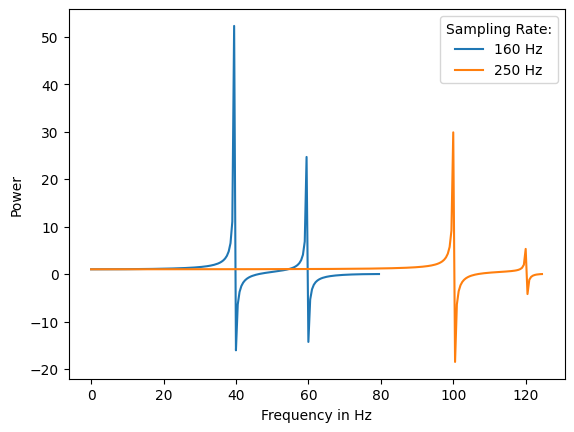

In [75]:
# Visualise positive spectrum for the two sampling rates
plt.plot(freq1[:T * Fs1 // 2], Y1[:T * Fs1 // 2], label=f"{Fs1} Hz")
plt.plot(freq2[:T * Fs2 // 2], Y2[:T * Fs2 // 2], label=f"{Fs2} Hz")

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(title="Sampling Rate:")

The signal sampled at 250 Hz correctly exhibits peaks at the original frequencies (100 and 120 Hz), whereas for the signal sampled at 160 Hz the peaks shifted to the left by 60 Hz, or half of the sampling rate, due to aliasing. Another effect of aliasing is the increase in the power at those two frequencies due to the additional artificial frequencies. Using an even higher sampling rate can further improve the spectrum and return a better estimate for the powers of the original frequencies.

## Task 3: Filters

### Section A

In [262]:
filters = np.load("data/filters.npy", allow_pickle=True)
filtVec = filters.item().get("filtVec")
dataVec = filters.item().get("dataVec").flatten()

In [263]:
def apply_filter(x, f):
    
    y = np.zeros((f.shape[0], x.size))

    for n in range(x.size):
        for k in range(filtVec.shape[1]):
            y[:, n] += f[:, k] * x[n - k]

    return y

In [264]:
impulse = np.zeros(filtVec.shape[1])
impulse[0] = 1

response = apply_filter(impulse, filtVec)

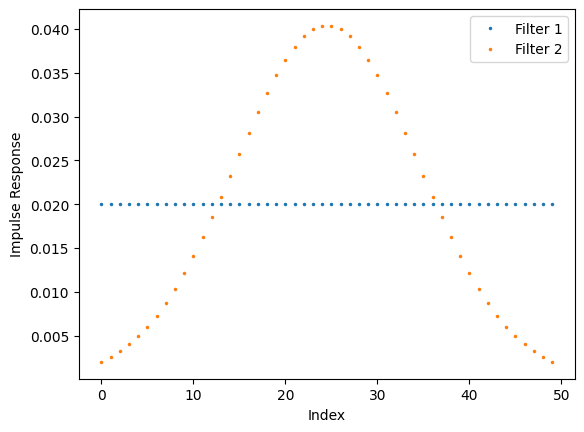

In [265]:
plt.plot(response.T, ".", markersize=3)

plt.xlabel("Index")
plt.ylabel("Impulse Response")
plt.legend(["Filter 1", "Filter 2"])

### Section B

In [266]:
y = apply_filter(dataVec, filtVec)

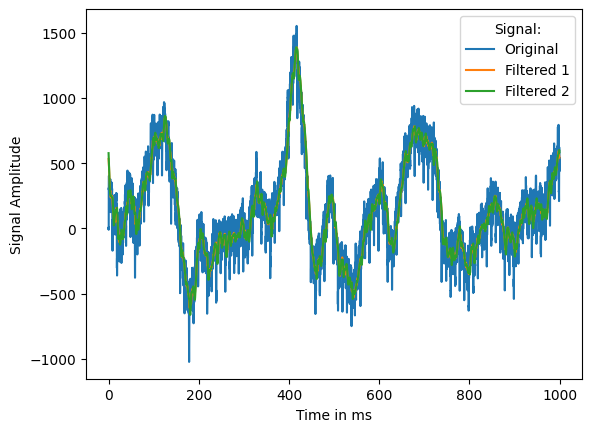

In [267]:
time = np.arange(dataVec.size) / 10
plt.plot(time, dataVec, linewidth=1.5)
plt.plot(time, y.T, linewidth=1.5)

plt.xlabel("Time in ms")
plt.ylabel("Signal Amplitude")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

### Section C

In [272]:
Fs = dataVec.size
T = 1

x = np.linspace(0, Fs * T, Fs)
xf = np.linspace(0, 1 / (2 * T), Fs // 2)

y0 = 2 / Fs * np.abs(fft(dataVec))[:Fs // 2]
yf = 2 / Fs * np.abs(fft(y))[:, :Fs // 2]

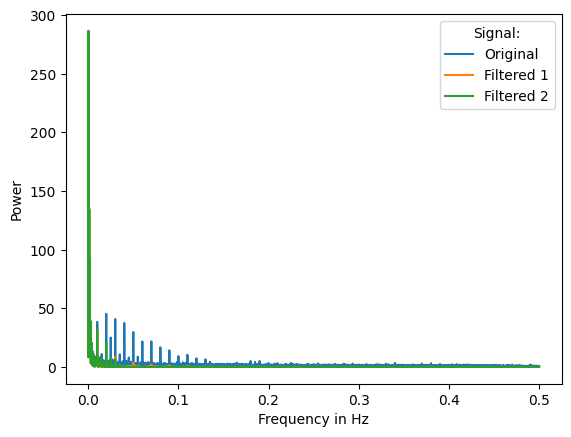

In [269]:
plt.plot(xf, y0)
plt.plot(xf, yf.T)

plt.xlabel("Frequency in Hz")
plt.ylabel("Power")
plt.legend(["Original", "Filtered 1", "Filtered 2"], title="Signal:")

Plotted only positive frequencies, resolution or frequency step is 1 / (2 * T) Hz, whereas max is Nyquist frequency Fs / 2 Hz.

### Section D

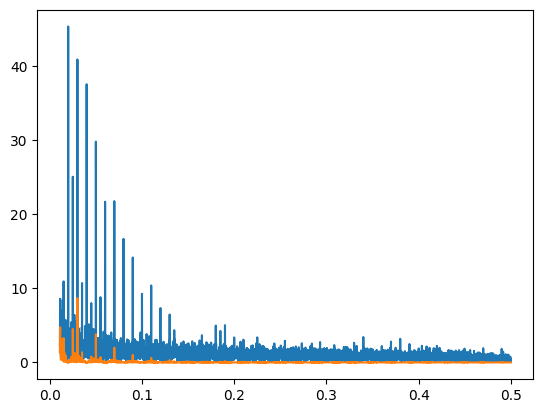

In [271]:
plt.plot(xf[110:], y0[110:])
plt.plot(xf[110:], yf[0, 110:].T)

Filter 1 is lowpass FIR with sharp descent and a lot of wripples. Filter 2 is lowpass FIR with gradual descent and few wripples.

### Section E

In [43]:
# cool that impulse response sums up to 1
np.sum(response, axis=1)

array([1., 1.])

Compared to ideal filter, filter 1 has lots of wripples due to sharp descent, whereas filter 2 does not have wripples but is not able to preserve original frequencies within the band because of very gradual ascent and descent.

## Task 4: PSD and Coherence

### Section A and B

In [10]:
coherence = np.load("data/coherence.npy", allow_pickle=True)
fwrsig_nospikes = coherence.item().get("fwrsig_nospikes").flatten()
st = coherence.item().get("st").toarray().flatten()

In [11]:
Fs = 24038

freq, fwr_power = welch(fwrsig_nospikes, Fs, noverlap=0, nperseg=2 * Fs)
freq, st_power = welch(st, Fs, noverlap=0, nperseg=2 * Fs)

fwr_power = fwr_power.flatten()
st_power = st_power.flatten()

In [13]:
min_plot_freq, min_norm_freq, max_freq = 3, 30, 70
norm_idx = np.where((freq >= min_norm_freq) & (freq <= max_freq))
plot_idx = np.where((freq >= min_plot_freq) & (freq <= max_freq))

norm_fwr_power = fwr_power[plot_idx] / np.sum(fwr_power[norm_idx])
norm_st_power = st_power[plot_idx] / np.sum(st_power[norm_idx])

threshold_fwr_power = fwr_power[norm_idx] / np.sum(fwr_power[norm_idx])
threshold_st_power = st_power[norm_idx] / np.sum(st_power[norm_idx])

In [14]:
fwr_mean = np.mean(threshold_fwr_power)
fwr_std = np.std(threshold_fwr_power)

st_mean = np.mean(threshold_st_power)
st_std = np.std(threshold_st_power)

fwr_threshold = fwr_mean + 5 * fwr_std
st_threshold = st_mean + 5 * st_std

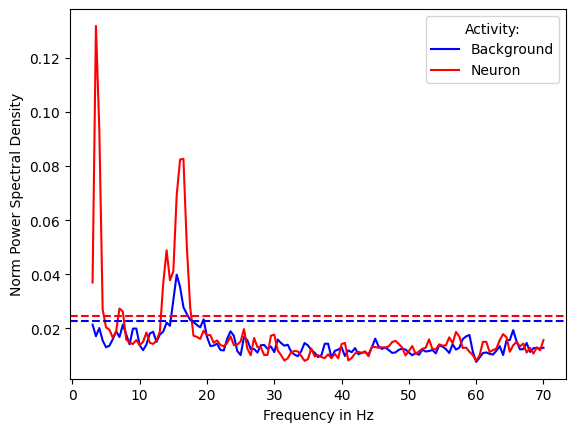

In [15]:
plt.plot(freq[plot_idx], norm_fwr_power, label="Background", c="b")
plt.plot(freq[plot_idx], norm_st_power, label="Neuron", c="r")

plt.axhline(y=fwr_threshold, linestyle="--", c="b")
plt.axhline(y=st_threshold, linestyle="--", c="r")

plt.xlabel("Frequency in Hz")
plt.ylabel("Norm Power Spectral Density")
plt.legend(title="Activity:")

In [21]:
fwr_keep = freq[plot_idx][norm_fwr_power > fwr_threshold]
st_keep = freq[plot_idx][norm_st_power > st_threshold]

print("Principal Oscillation Frequencies (Hz):")
print(f"fwr: {fwr_keep}")
print(f"st: {st_keep}")

Principal Oscillation Frequencies (Hz):
fwr: [15.  15.5 16.  16.5 17.  17.5 19.5]
st: [ 3.   3.5  4.   4.5  7.   7.5 13.5 14.  14.5 15.  15.5 16.  16.5 17.
 17.5]


### Section C

In [22]:
freq, cross_spectrum = csd(fwrsig_nospikes, st, Fs, noverlap=0, nperseg=2 * Fs)
cross_spectrum = cross_spectrum[plot_idx]

Text(0, 0.5, 'Cross Spectral Density')

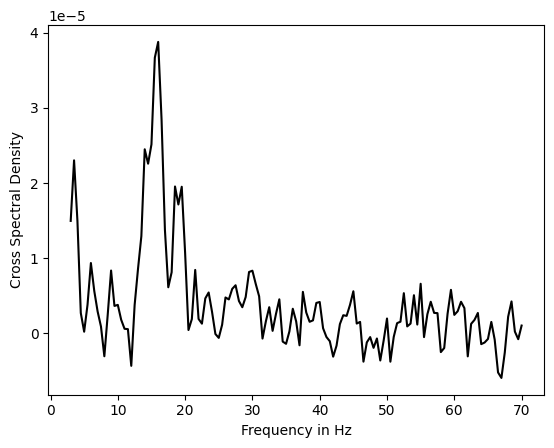

In [23]:
plt.plot(freq[plot_idx], cross_spectrum, label="Background", c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Cross Spectral Density")

### Section D

In [24]:
coherence = np.abs(cross_spectrum)**2 / (fwr_power[plot_idx] * st_power[plot_idx])

Text(0, 0.5, 'Coherence')

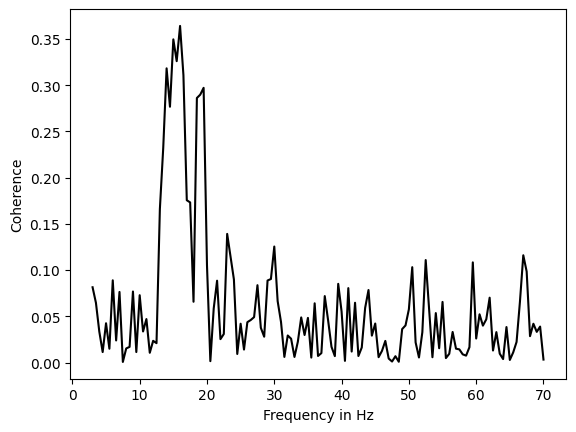

In [25]:
plt.plot(freq[plot_idx], coherence, c="k")

plt.xlabel("Frequency in Hz")
plt.ylabel("Coherence")

### Section E

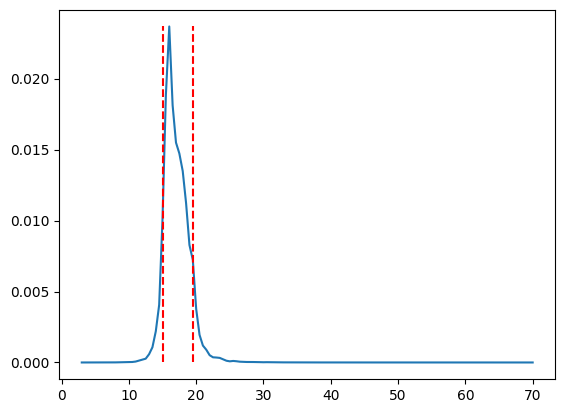

In [93]:
# Design Butterworth filter for background activity
b, a = butter(2, [fwr_keep[0], fwr_keep[-1]], btype="band", fs=Fs)

# Apply filter to background activity
filtered_fwr = lfilter(b, a, fwrsig_nospikes)

freq, filtered_fwr_power = welch(filtered_fwr, fs=Fs, noverlap=0, nperseg=2 * Fs)

#plt.plot(filtered_fwr, label="Background")

plt.plot(freq[plot_idx], filtered_fwr_power[plot_idx])
plt.vlines(
    [fwr_keep[0], fwr_keep[-1]],
    ymin=0, ymax=max(filtered_fwr_power),
    color="red", linestyle="--"
)

In [66]:
st_keep

array([ 3. ,  3.5,  4. ,  4.5,  7. ,  7.5, 13.5, 14. , 14.5, 15. , 15.5,
       16. , 16.5, 17. , 17.5])

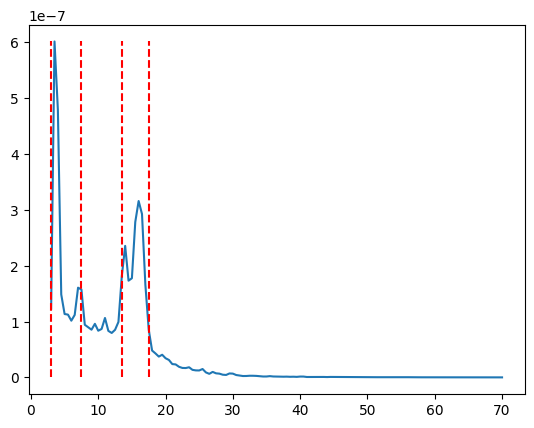

In [91]:
#b1, a1 = butter(2, [st_keep[0], st_keep[-1]], fs=Fs, btype="band")
#b2, a2 = iirnotch(5.25, 5.25 / 0.5, fs=Fs)
b3, a3 = butter(2, [st_keep[5], st_keep[6]], fs=Fs, btype="stop")

#filtered_st = lfilter(b1, a1, st)
#filtered_st = lfilter(b1, a1, filtered_st)
filtered_st = lfilter(b1, a1, st)

freq, filtered_st_power = welch(filtered_st, fs=Fs, noverlap=0, nperseg=2 * Fs)

plt.plot(freq[plot_idx], filtered_st_power[plot_idx])
plt.vlines(
    [st_keep[0], st_keep[5], st_keep[6], st_keep[-1]],
    ymin=0, ymax=max(filtered_st_power),
    color="red", linestyle="--"
)

In [52]:
# Set bandwidth as half frequency resolution
bandwidth = 0.25

# Design IIR peak filter for 
b, a = iirpeak(fwr_keep, fwr_keep / bandwidth, Fs)
filtered_fwr = lfilter(b, a, fwrsig_nospikes)

# Design IIR peak filter for stimulus activity
b, a = iirpeak(st_keep, st_keep / bandwidth, Fs)
# Apply filter to stimulus activity
filtered_st = lfilter(b, a, st)

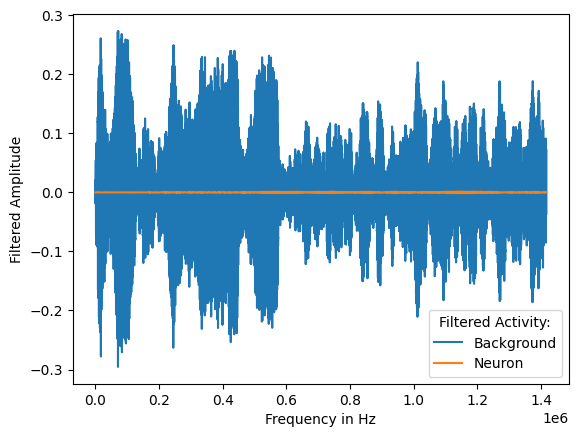

In [53]:
plt.plot(filtered_fwr, label="Background")
plt.plot(filtered_st, label="Neuron")

plt.xlabel("Frequency in Hz")
plt.ylabel("Filtered Amplitude")
plt.legend(title="Filtered Activity:")

In [94]:
analytic_fwr = hilbert(filtered_fwr)
spike_background = analytic_fwr[st == 1]

amplitude_envelope = np.abs(spike_background)
phase = np.angle(spike_background)

phase_mean = np.rad2deg(circmean(phase, low=phase.min(), high=phase.max()))

print(f"Most exciting phase computed by circular mean: {phase_mean:.3g}°")

Most exciting phase computed by circular mean: -17.7°


Text(0.5, 1.0, 'Phase of Background Activity upon Spike')

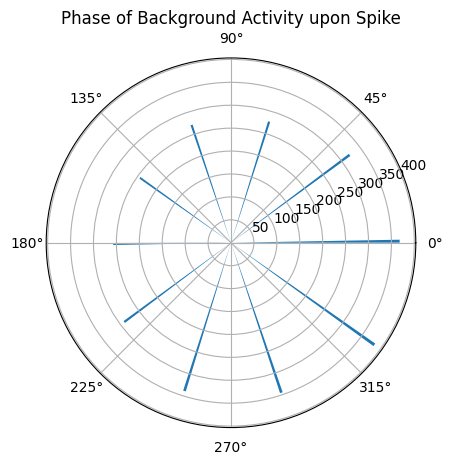

In [99]:
ax = plt.subplot(polar=True)

ax.hist(phase, width=np.deg2rad(1))

ax.set_title("Phase of Background Activity upon Spike")

### Section F

Describe differences, pluses and cons of coherence and phase locking.

## References

1. Ayzenshtat, Inbal, et al. "Precise spatiotemporal patterns among visual cortical areas and their relation to visual stimulus processing." Journal of Neuroscience 30.33 (2010): 11232-11245.
2. Shoham, Doron, et al. "Imaging cortical dynamics at high spatial and temporal resolution with novel blue voltage-sensitive dyes." Neuron 24.4 (1999): 791-802.
